In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!python -V

Python 3.10.12


In [3]:
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 26.3 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.8.0-py3-none-any.whl size=292701 sha256=44bc82ad22a54333aaef7fdc7036575377f17fd33d905b1e0721b56a44f8778f
  Stored in directory: /root/.cache/pip/wheels/2d/cc/dc/7ec84dced25f738b8be400101abb67e4b50c905090a51017e4
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, ht

In [4]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [5]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-d8_b_nlg/kobert-tokenizer_dda98671a8384d64ae605f02de4521bb
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-d8_b_nlg/kobert-tokenizer_dda98671a8384d64ae605f02de4521bb
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4632 sha256=923acd0a2f1a42731df9c536b267179152268893d23cd85b3f7466ee59fd8960
  Stored in directory: /tmp/pip-ephem-wheel-cache-wczck1u3/wheels/e9/1a/3f/a864970e8a169c176befa3c4a1e07aa612f69195907a4045fe
Successfully built kobert_tokenizer


In [6]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

/usr/local/lib/python3.10/dist-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


In [7]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel
from transformers.optimization import get_cosine_schedule_with_warmup

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [185]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

## 사용자 정의 토큰 추가 - 모호한의미 or 중요한 단어
new_tokens = ['우울', '슬픔', '외로움', '분노', '무기력', '의욕상실', '식욕저하', '식욕증가', '감정조절이상',
              '불면', '초조', '피로', '죄책감', '집중력저하', '자신감저하', '자존감저하', '절망', '자살', '불안']
tokenizer.add_tokens(new_tokens)
# 사용자 토큰 추가했던 것 bertmodel 의 embedding_layer에도 추가해줘야함
bertmodel.resize_token_embeddings(len(tokenizer))

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


Embedding(8021, 768)

In [186]:
class BERTSentenceTransform:

    def __init__(self, tokenizer, max_seq_length, vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab ##추가

    def __call__(self, line):


        # 유니코드로 변환
        text_a = line[0]
        if self._pair:
            assert len(line) == 2  # 2개로 이뤄진문장 있을 수 있음
            text_b = line[1]

        #tokens_a = self._tokenizer(text_a)
        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # `tokens_a` 와 `tokens_b` max_seq_length-3을 넘지 않도록 수정
            # [CLS], [SEP], [SEP]를 포함하므로 "- 3" 들어가야함
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # 문장 한 개일 경우 [CLS], [SEP] 두 개이므로 "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]


        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        #input_ids = tokens_a['input_ids']

        # 문장의 유효길이 valid_length는 input_ids의 길이. 그 이외는 0 패딩
        valid_length = len(input_ids)

        if self._pad:
            # 시퀀스 길이만큼 0 패딩
            padding_length = self._max_seq_length - valid_length
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

#데이터셋 input_ids, valid_length, segment_ids 로
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len, pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 num_classes,
                 hidden_size = 768,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

#데이터셋1 - 우울1: 비우울1

In [187]:
emotion_dict = {0: '감정조절이상', 1: '불면', 2: '분노', 3: '불안', 4: '초조', 5: '슬픔', 6: '외로움', 7: '우울', 8: '의욕상실', 9: '무기력',
                10: '자살', 11: '자존감저하', 12: '절망', 13: '죄책감', 14: '집중력저하', 15: '피로', 16: '식욕저하', 17: '식욕증가', 18: '일상'}

In [188]:
# emotion_dict 기반으로 label column 생성

import pandas as pd
import re

df = pd.read_csv('/content/drive/MyDrive/KOBERT/data/intent_dataset_method1.csv',
                                                                                                                                              encoding='utf-8')

emotion_mapping = {label: key for key, label in emotion_dict.items()}
df['intent'] = df['intent'].map(emotion_mapping)

# 데이터셋을 각각의 리스트형식으로 변환 : input 형식
data_list1 = [[re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣\s\.]', '', q),
                          str(label)] for q, label in zip(df['document'], df['intent'])]

In [189]:
print(len(data_list1), '\n')
data_list1[:15]

9576 



[['제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.', '0'],
 ['더 이상 내 감정을 내가 컨트롤 못 하겠어.', '0'],
 ['하루종일 오르락내리락 롤러코스터 타는 기분이에요.', '0'],
 ['꼭 롤러코스터 타는 것 같아요.', '0'],
 ['롤러코스터 타는 것처럼 기분이 왔다 갔다 해요.', '0'],
 ['작년 가을부터 감정조절이 잘 안 되는 거 같아.', '0'],
 ['예전에 비해서 인내심이 너무 짧아진 거 같아.', '0'],
 ['더 이상 혼자서는 감정조절을 못하겠어.', '0'],
 ['점점 나 자신을 컨트롤하지 못하는 기분이야.', '0'],
 ['나도 이러기 싫은데 내 마음대로 안돼.', '0'],
 ['맨정신일 때는 저를 주체할 수 가 없었거든요.', '0'],
 ['주체가 안 돼.', '0'],
 ['이렇게 쌓이고 쌓이다 나중에 확 터지거든요. 진짜 걷잡을 수 없이요.', '0'],
 ['근데 감정을 다스리지 못해 욱하기도하고.', '0'],
 ['순간순간 감정조절을 못해요.', '0']]

# 데이터셋2 - 우울 18: 비우울 1 ( 우울 각 양상 1: 비우울 1 )

In [190]:
# emotion_dict 기반으로 label column 생성

import pandas as pd
import re

df = pd.read_csv('/content/drive/MyDrive/KOBERT/data/intent_dataset_method2.csv',
                                                                                                                                              encoding='utf-8')

emotion_mapping = {label: key for key, label in emotion_dict.items()}
df['intent'] = df['intent'].map(emotion_mapping)

# 데이터셋을 각각의 리스트형식으로 변환 : input 형식
data_list2 = [[re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣\s\.]', '', q),
                          str(label)] for q, label in zip(df['document'], df['intent'])]

In [191]:
print(len(data_list2), '\n')
data_list2[:15]

5026 



[['제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.', '0'],
 ['더 이상 내 감정을 내가 컨트롤 못 하겠어.', '0'],
 ['하루종일 오르락내리락 롤러코스터 타는 기분이에요.', '0'],
 ['꼭 롤러코스터 타는 것 같아요.', '0'],
 ['롤러코스터 타는 것처럼 기분이 왔다 갔다 해요.', '0'],
 ['작년 가을부터 감정조절이 잘 안 되는 거 같아.', '0'],
 ['예전에 비해서 인내심이 너무 짧아진 거 같아.', '0'],
 ['더 이상 혼자서는 감정조절을 못하겠어.', '0'],
 ['점점 나 자신을 컨트롤하지 못하는 기분이야.', '0'],
 ['나도 이러기 싫은데 내 마음대로 안돼.', '0'],
 ['맨정신일 때는 저를 주체할 수 가 없었거든요.', '0'],
 ['주체가 안 돼.', '0'],
 ['이렇게 쌓이고 쌓이다 나중에 확 터지거든요. 진짜 걷잡을 수 없이요.', '0'],
 ['근데 감정을 다스리지 못해 욱하기도하고.', '0'],
 ['순간순간 감정조절을 못해요.', '0']]

# train_test_split

In [192]:
from sklearn.model_selection import train_test_split

def split_dataset(data_list, max_len):
  dataset_train, dataset_test = train_test_split(data_list, test_size=0.1, random_state=42)
  print(len(dataset_train), ' ', len(dataset_test),'\n')
  print(dataset_train[110:115])
  print(dataset_test[110:115])

  data_train = BERTDataset(dataset_train, 0, 1, tokenizer, vocab, max_len, True, False)
  data_test = BERTDataset(dataset_test, 0, 1, tokenizer, vocab, max_len, True, False)

  print(data_train[0][0], '\n')
  print(data_test[0][0])

  return data_train, data_test

# 각 dataset 비교

# 1. epoch 10, batch_size=32, earlystop 적용
# accuracy, f1-score, loss


In [193]:
# 파라미터
max_len = 40
batch_size = 16
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  (5e-5)

In [194]:
data1_train, data1_test = split_dataset(data_list1, max_len)

train_dataloader1 = torch.utils.data.DataLoader(data1_train, batch_size=batch_size, num_workers=2)
test_dataloader1 = torch.utils.data.DataLoader(data1_test, batch_size=batch_size, num_workers=2)
train_dataloader1

8618   958 

[['당연히 같이 운동하는 사람들이 있어 이번에 대회도 같이 참가했어.', '18'], ['같이 뛰기도 하고 혼자 뛰기도 해.', '18'], ['그리고 한 가지 일에 집중을 못 해. 되게 혼자 엄청 분주해져.', '14'], ['누가 저를 해칠 것 같아요', '11'], ['인생이 즐겁지가 않아.', '9']]
[['꼭 롤러코스터 타는 것 같아요.', '0'], ['많이 자도 졸려워', '1'], ['압력을 가할 때가 있어.', '0'], ['나쁜 인간 된 기분이야', '13'], ['괴로워서 미치겠어.', '9']]
[   2 4902 4924 5757 6004 4955 5793 1754 4627 6116 2086 1931 5671 6887
 4627 6116 3697 1307 6896 1933 6394 5405 6855   54 1458 3010 5655    3
    1    1    1    1    1    1    1    1    1    1    1    1] 

[   2 2753 5760 3097 5439   54 1435 1907 6003 7632 7088 4207 7850 1986
 6328 3363 1907 6003 7632 1434 7953 6896 4585 7788 3868   54   54    3
    1    1    1    1    1    1    1    1    1    1    1    1]


In [195]:
data2_train, data2_test = split_dataset(data_list2, max_len)

train_dataloader2 = torch.utils.data.DataLoader(data2_train, batch_size=batch_size, num_workers=2)
test_dataloader2 = torch.utils.data.DataLoader(data2_test, batch_size=batch_size, num_workers=2)
train_dataloader2

4523   503 

[['몸무게가 줄었더라', '16'], ['너무 외롭고 모든 게 의미 없이 느껴져요.', '6'], ['모든 게 서글프고 허무했거든.', '5'], ['희망도 없어요', '12'], ['다 져서 망했어', '13']]
[['그때부터 조금씩 불안해지더라고요.', '3'], ['감정기복 때문에 힘들다', '4'], ['그럼 잠도 못자고 별의별 생각이 다 나요.', '1'], ['압박감 때문에 미치겠어', '3'], ['잠을 못 잤더니 기운이 없음', '1']]
[   2 1370 7417 8002 4926 8006 4955 2589 1861 3881    3    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1] 

[   2  517 6794 5760  921 3059 6553 1189 4213 6664  833  517 5378 1907
 6601   54    3    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1]


# 모델훈련

In [196]:
train_dataloader = train_dataloader2

# 모델 정의 - pretrained bertmodel, num_classes, dr_rate 등 지정
model = BERTClassifier(bertmodel, num_classes = 19, dr_rate=0.5).to(device)

# optimizer, schedule
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

# 손실 함수 설정
loss_fn = nn.CrossEntropyLoss()

# 전체 훈련 스텝 수 설정
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)


# 정확도 계산 함수
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().item() / max_indices.size()[0]
    return train_acc

In [197]:
from sklearn.metrics import f1_score
import numpy as np

history = {'train_acc': [], 'train_f1': [], 'train_loss': [], 'test_acc': [], 'test_f1': []}

best_test_f1 = 0.0  # 가장 높은 검증 F1 스코어를 저장할 변수
patience = 3  # early stopping을 위한 기다리는 최대 epoch 수
early_stopping_counter = 0  # early stopping 카운터

for e in range(num_epochs):
    train_acc = 0.0
    train_f1 = 0.0
    train_loss = 0.0
    train_preds = []
    train_labels = []

    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()

        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        loss = loss_fn(out, label)
        loss.backward()
        train_loss = loss.data.cpu().numpy()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_acc += calc_accuracy(out, label)
        train_preds += out.argmax(dim=-1).tolist()
        train_labels += label.tolist()

        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, train_loss, train_acc / (batch_id+1)))
    train_f1 = f1_score(train_labels, train_preds, average='weighted')
    print("epoch {} train acc {} train f1 {}".format(e+1, train_acc / (batch_id+1), train_f1))
    history['train_acc'].append((train_acc / (batch_id+1)))
    history['train_f1'].append(train_f1)
    history['train_loss'].append(train_loss)

    model.eval()
    test_acc = 0.0
    test_f1 = 0.0
    test_preds = []
    test_labels = []

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader1)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_acc += calc_accuracy(out, label)
        test_preds += out.argmax(dim=-1).tolist()
        test_labels += label.tolist()

    test_f1 = f1_score(test_labels, test_preds, average='weighted')

    print("epoch {} test acc {} test f1 {}".format(e+1, test_acc / (batch_id+1), test_f1))
    # Save to history
    history['test_acc'].append((test_acc / (batch_id+1)))
    history['test_f1'].append(test_f1)

    if test_f1 > best_test_f1:  # 검증 F1 스코어가 이전보다 높을 경우
        best_test_f1 = test_f1
        early_stopping_counter = 0  # early stopping 카운터 초기화
    else:
        early_stopping_counter += 1  # 검증 F1 스코어가 이전과 같거나 낮을 경우 카운터 증가

    if early_stopping_counter >= patience:  # early stopping 카운터가 patience 값 이상일 경우 학습 종료
        print(f"Early stopping at epoch {e+1}")
        break

  1%|          | 2/283 [00:00<01:04,  4.39it/s]

epoch 1 batch id 1 loss 2.9570484161376953 train acc 0.0625


 71%|███████▏  | 202/283 [00:28<00:11,  6.90it/s]

epoch 1 batch id 201 loss 2.2433571815490723 train acc 0.16169154228855723


100%|██████████| 283/283 [00:40<00:00,  6.98it/s]


epoch 1 train acc 0.2164913266945069 train f1 0.1780410662967314


100%|██████████| 60/60 [00:02<00:00, 22.67it/s]


epoch 1 test acc 0.5699404761904762 test f1 0.5578298201407099


  1%|          | 2/283 [00:00<00:54,  5.11it/s]

epoch 2 batch id 1 loss 2.0877411365509033 train acc 0.3125


 71%|███████▏  | 202/283 [00:28<00:11,  7.22it/s]

epoch 2 batch id 201 loss 1.2395962476730347 train acc 0.47388059701492535


100%|██████████| 283/283 [00:39<00:00,  7.11it/s]


epoch 2 train acc 0.5296137166720205 train f1 0.49504278465024765


100%|██████████| 60/60 [00:02<00:00, 23.02it/s]


epoch 2 test acc 0.8007440476190476 test f1 0.7989193759127919


  1%|          | 2/283 [00:00<00:54,  5.14it/s]

epoch 3 batch id 1 loss 1.0872172117233276 train acc 0.6875


 71%|███████▏  | 202/283 [00:28<00:11,  7.04it/s]

epoch 3 batch id 201 loss 0.5727816224098206 train acc 0.7555970149253731


100%|██████████| 283/283 [00:40<00:00,  7.04it/s]


epoch 3 train acc 0.7786098618695791 train f1 0.7679933034567105


100%|██████████| 60/60 [00:02<00:00, 22.68it/s]


epoch 3 test acc 0.9123511904761905 test f1 0.9134199754003474


  1%|          | 2/283 [00:00<00:55,  5.10it/s]

epoch 4 batch id 1 loss 0.5847798585891724 train acc 0.9375


 71%|███████▏  | 202/283 [00:28<00:11,  7.04it/s]

epoch 4 batch id 201 loss 0.2847627103328705 train acc 0.8837064676616916


100%|██████████| 283/283 [00:40<00:00,  7.05it/s]


epoch 4 train acc 0.8906802120141343 train f1 0.8880011967890561


100%|██████████| 60/60 [00:02<00:00, 23.00it/s]


epoch 4 test acc 0.9300595238095238 test f1 0.9324920256652696


  1%|          | 2/283 [00:00<00:54,  5.12it/s]

epoch 5 batch id 1 loss 0.35682153701782227 train acc 1.0


 71%|███████▏  | 202/283 [00:28<00:11,  7.04it/s]

epoch 5 batch id 201 loss 0.27997973561286926 train acc 0.927860696517413


100%|██████████| 283/283 [00:40<00:00,  7.02it/s]


epoch 5 train acc 0.928786540314809 train f1 0.926887467785819


100%|██████████| 60/60 [00:02<00:00, 22.73it/s]

epoch 5 test acc 0.9290178571428572 test f1 0.9315699788405526


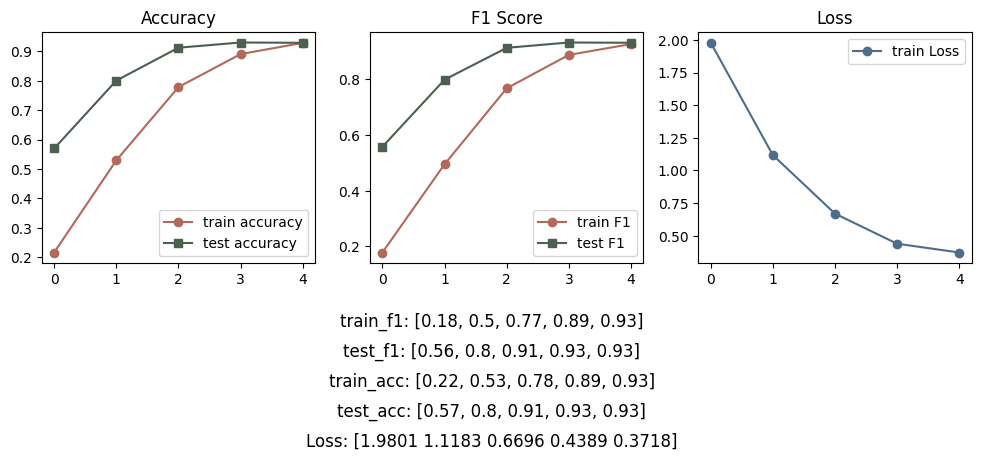

In [198]:
import matplotlib.pyplot as plt

# 시각화
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.plot(history['train_acc'], color='#B3685C', marker='o', label='train accuracy')
plt.plot(history['test_acc'], color='#4C6050', marker='s', label='test accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['train_f1'], color='#B3685C', marker='o', label='train F1')
plt.plot(history['test_f1'], color='#4C6050', marker='s', label='test F1')
plt.title('F1 Score')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history['train_loss'], color='#4F6C8C', marker='o', label='train Loss')
plt.title('Loss')
plt.legend()

# 지표 값 출력
train_f1_rounded = [round(value, 2) for value in history['train_f1']]
test_f1_rounded = [round(value, 2) for value in history['test_f1']]
train_acc_rounded = [round(value, 2) for value in history['train_acc']]
test_acc_rounded = [round(value, 2) for value in history['test_acc']]
train_loss_rounded = np.round(history['train_loss'], 4)  # NumPy 배열에 round 함수 적용

plt.figtext(0.5, -0.3, f"train_acc: {train_acc_rounded}", ha='center', fontsize=12)
plt.figtext(0.5, -0.1, f"train_f1: {train_f1_rounded}", ha='center', fontsize=12)
plt.figtext(0.5, -0.4, f"test_acc: {test_acc_rounded}", ha='center', fontsize=12)
plt.figtext(0.5, -0.2, f"test_f1: {test_f1_rounded}", ha='center', fontsize=12)
plt.figtext(0.5, -0.5, f"Loss: {train_loss_rounded}", ha='center', fontsize=12)

plt.show()

In [142]:
torch.save(model,f'/content/drive/MyDrive/KOBERT/model/depress/epoch5/kobert_text_depress_model_batch{batch_size}_LR{learning_rate}.pt')
torch.save

<function torch.serialization.save(obj: object, f: Union[str, os.PathLike, BinaryIO, IO[bytes]], pickle_module: Any = <module 'pickle' from '/usr/lib/python3.10/pickle.py'>, pickle_protocol: int = 2, _use_new_zipfile_serialization: bool = True) -> None>

In [112]:
print('train_f1:', history['train_f1'])
print('test_f1:', history['test_f1'])
print('train_acc:', history['train_acc'])
print('test_acc:', history['test_acc'])
print('Loss:')
for loss in history['train_loss'] : print(loss, '  ')

train_f1: [0.14414738013622708, 0.45717809060255843, 0.7246123457432082, 0.859491741117093, 0.8987840322043262]
test_f1: [0.4714103138555023, 0.7696281331285317, 0.8934460411179261, 0.9161914616110828, 0.9096469469283187]
train_acc: [0.16670012849341473, 0.49297301638291036, 0.741848699004176, 0.8691575650497911, 0.9052762608416318]
test_acc: [0.48005952380952377, 0.7800595238095238, 0.8967261904761905, 0.9154761904761906, 0.9081845238095239]
Loss:
2.090656   
1.2359768   
0.85164493   
0.4567664   
0.5100544   


# 예측

In [ ]:
model = torch.load("/content/drive/MyDrive/KOBERT/model/kobert_text_depress_model_epoch10.pt")
print(model)

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8021, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

# 예측

In [ ]:
!pip install kss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 67.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kss: filename=kss-4.5.3-py3-none-any.whl size=54258 sha256=729e5d4a65b3edabe947e9ff1c33cac891a3aab1979a7cbcee77602bb4fb998a
  Stored in directory: /root/.cache/pip/wheels/d8/9e/a3/5b09e3f14722fa0d77f47fe840668d426760023bdd11b0fbd9
  Created wheel for pecab: filename=pecab-1.0.8-py3-none-any.whl size=26646666 sha256=a37ba4545fc8659a3e31b196a55f91e22d086b88563ebfbc861f04ac4debeb78
  Stored in directory: /root/.cache/pip/wheels/5c/6f/b4/ab61b8863d7d8b1409def8ae31adcaa089fa91b8d022ec309d
Successfully built kss pecab


In [ ]:
from kss import split_sentences

# 생성된 문장 맞춤법 교정
def correct_spelling(text_list):
    tmp_list = []
    for t in text_list :
        spelled_sent = spell_checker.check(t)
        checked_sent = spelled_sent.checked
        tmp_list.append(checked_sent)
    return tmp_list

In [ ]:
"""
사용자 입력을 분석하여 감정 상태를 추론하고, 감정에 대한 점수를 반환하는 함수.
"""
from torch.nn import Softmax
from kss import split_sentences

def model_output(model, user_input,batch_size, tokenizer):

    predict_sentences = split_sentences(user_input)

    # 사용자 데이터셋 생성
    user_dataset = [[sentence, '0']  for sentence in predict_sentences]
    print(user_dataset)

    # logits 리스트 초기화
    logits_list = []

    # BERT 데이터셋 준비
    user_dataset_ids = BERTDataset(user_dataset, 0, 1, tokenizer, vocab, max_len, True, False)
    user_dataset_dataloader = torch.utils.data.DataLoader(user_dataset_ids, batch_size=batch_size, num_workers=2)

    # 모델을 사용하여 예측값 계산
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(user_dataset_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length.to(device)

        output = model(token_ids, valid_length, segment_ids)

        # 출력값 저장
        for logits in output:
            logits = logits.detach().cpu().numpy()
            logits_list.append(logits)

    return logits_list


## 우울 모델 함수
def Analyze_fn_depress(logits_list):

    depress_list = []

    # 감정 사전
    depress_dict = {0: '감정조절이상', 1: '불면', 2: '분노', 3: '불안', 4: '초조', 5: '슬픔', 6: '외로움', 7: '우울', 8: '의욕상실', 9: '무기력',
                10: '자살', 11: '자존감저하', 12: '절망', 13: '죄책감', 14: '집중력저하', 15: '피로', 16: '식욕저하', 17: '식욕증가', 18: '일상'}

    # softmax 점수 계산
    for logits in logits_list:
        softmax = Softmax(dim=0)
        score = softmax(torch.tensor(logits))  # 음성과 함께 사용할 예정
        max_value, max_index = torch.max(score, dim=0)

        emotion = depress_dict[int(max_index)]

        # 50% 이하인 경우 '일상'으로 지정 - 애매한 문장은 중립ㅋ
        if max_value.item() <= 0.6:
            print("emotion :", emotion, "일 확률", round(100 * (max_value.item()), 2), "%")
            emotion = '일상'

        else :
            print("emotion :", emotion, "일 확률", round(100 * (max_value.item()), 2), "%")

        depress_list.append(emotion)


    # 이 부분 수정 보완하기
    if (depress_list.count('일상')) != len(depress_list):
        depress_value = round((len(depress_list) - depress_list.count('일상')) / len(depress_list), 2)
    else :
        depress_value = 0.0

    return [depress_list, depress_value]

In [ ]:
## test1. 우울 문장 있을 경우
user_input = '오늘은 업무의 압박과 스트레스 때문에 정말로 힘들었다 일 끝나고 집에 오니까 참기 힘들 정도로 피곤했는데, 이런 일상에 지쳐버린 것 같아 너무 우울하다 친한 친구와의 갈등으로 많은 상처를 받았다 그동안 함께 지냈던 소중한 인연이 이렇게도 쉽게 깨질 수 있다는 생각에 너무 슬펐다 가족과의 갈등 때문에 기운이 빠진 하루였다 말하면서 다투는 것마저도 지쳐버렸는데, 이렇게 쟁쟁한 가족관계에 처해있는 것만으로도 너무 힘들고 우울하다 일상의 지루함과 무기력함에 시달려 힘들게 보냈다 아무것도 할 엄두가 나지 않아서 그저 침대에 누워있는데, 이런 나 자신이 너무 싫고 우울하다'

print(user_input)
depress = Analyze_fn_depress(model_output(model ,user_input, batch_size, tokenizer))
print(depress)

오늘은 업무의 압박과 스트레스 때문에 정말로 힘들었다 일 끝나고 집에 오니까 참기 힘들 정도로 피곤했는데, 이런 일상에 지쳐버린 것 같아 너무 우울하다 친한 친구와의 갈등으로 많은 상처를 받았다 그동안 함께 지냈던 소중한 인연이 이렇게도 쉽게 깨질 수 있다는 생각에 너무 슬펐다 가족과의 갈등 때문에 기운이 빠진 하루였다 말하면서 다투는 것마저도 지쳐버렸는데, 이렇게 쟁쟁한 가족관계에 처해있는 것만으로도 너무 힘들고 우울하다 일상의 지루함과 무기력함에 시달려 힘들게 보냈다 아무것도 할 엄두가 나지 않아서 그저 침대에 누워있는데, 이런 나 자신이 너무 싫고 우울하다
[['오늘은 업무의 압박과 스트레스 때문에 정말로 힘들었다', '0'], ['일 끝나고 집에 오니까 참기 힘들 정도로 피곤했는데, 이런 일상에 지쳐버린 것 같아 너무 우울하다 친한 친구와의 갈등으로 많은 상처를 받았다', '0'], ['그동안 함께 지냈던 소중한 인연이 이렇게도 쉽게 깨질 수 있다는 생각에 너무 슬펐다 가족과의 갈등 때문에 기운이 빠진 하루였다 말하면서 다투는 것마저도 지쳐버렸는데, 이렇게 쟁쟁한 가족관계에 처해있는 것만으로도 너무 힘들고 우울하다 일상의 지루함과 무기력함에 시달려 힘들게 보냈다', '0'], ['아무것도 할 엄두가 나지 않아서 그저 침대에 누워있는데, 이런 나 자신이 너무 싫고 우울하다', '0']]
emotion : 일상 일 확률 79.24 %
emotion : 우울 일 확률 97.08 %
emotion : 감정조절이상 일 확률 65.85 %
emotion : 우울 일 확률 97.06 %
[['일상', '우울', '감정조절이상', '우울'], 0.75]


In [ ]:
# test2. 일상 일기
user_input = '오늘은 햇빛이 환하게 비치는 아름다운 날이었습니다 나는 일어나자마자 신나게 노래를 틀고 춤을 추면서 하루를 시작했습니다 아침 식사 후에는 친구들과 함께 공원에 나가서 피크닉을 즐겼습니다 우리는 함께 먹을 음식을 각자 준비해서 가져와서 다양한 요리를 공유했습니다 즐거운 이야기와 웃음 속에서 시간이 흘러갔고, 우리는 미니 게임을 열었습니다 경쟁하면서도 서로를 응원하며 즐거운 시간을 보냈습니다'
depress = Analyze_fn_depress(model_output(model ,user_input, batch_size, tokenizer))
print(depress)

[['오늘은 햇빛이 환하게 비치는 아름다운 날이었습니다', '0'], ['나는 일어나자마자 신나게 노래를 틀고 춤을 추면서 하루를 시작했습니다', '0'], ['아침 식사 후에는 친구들과 함께 공원에 나가서 피크닉을 즐겼습니다', '0'], ['우리는 함께 먹을 음식을 각자 준비해서 가져와서 다양한 요리를 공유했습니다', '0'], ['즐거운 이야기와 웃음 속에서 시간이 흘러갔고, 우리는 미니 게임을 열었습니다', '0'], ['경쟁하면서도 서로를 응원하며 즐거운 시간을 보냈습니다', '0']]
emotion : 일상 일 확률 33.8 %
emotion : 일상 일 확률 87.09 %
emotion : 일상 일 확률 99.92 %
emotion : 일상 일 확률 99.89 %
emotion : 일상 일 확률 99.95 %
emotion : 일상 일 확률 99.94 %
[['일상', '일상', '일상', '일상', '일상', '일상'], 0.0]
